In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

In [ ]:
def imageMaskDimentionMatch(images, masks):
    masks_dimention_matched = np.zeros(images.shape)
    masks_dimention_matched[:, :masks.shape[1], :masks.shape[2]] = masks[:, :masks.shape[1], :masks.shape[2]]

    return masks_dimention_matched

In [3]:
def mask_index_standardisation(mask):
    unique = np.unique(mask)
    dict_unique = {}
    mask_copy = mask.copy()

    for i in range(unique.size):
        dict_unique[i] = unique[i]
        replace = mask == unique[i]
        mask_copy = np.where(replace, int(i), mask_copy)
    
    return mask_copy

def mask_index_standardisation_stack(stack):
    stack_standardized = np.empty(stack.shape)
    for i in range(stack.shape[0]):
        stack_standardized[i] = mask_index_standardisation(stack[i])

    return stack_standardized


In [ ]:
def mask_preprocessing(path_images, path_mask):
    masks = tifffile.imread(path_mask)
    images = tifffile.imread(path_images)

    mask_dim_matched = imageMaskDimentionMatch(images=images, masks=masks)
    mask_idx_standardised = mask_index_standardisation_stack(mask_dim_matched)
    
    tifffile.imwrite(path_mask, mask_idx_standardised)

In [81]:
# Load tiff stack images and masks

# S2 Only
large_images = tifffile.imread("/Users/jakesolsky/PlateletImageSegmentation/Data/Training Data/Images/S3.tif")
print(large_images.shape)
large_masks = tifffile.imread("/Users/jakesolsky/PlateletImageSegmentation/Data/Training Data/Masks/Mask_S3.tif")
print(large_masks.shape)
# autoseg_masks = tifffile.imread("/Users/jakesolsky/PlateletImageSegmentation/Models/microSAM/TIRF_autosegment_results/S2_auto_segmentation_vit_b_lm.tif")

(101, 256, 256)
(101, 256, 256)


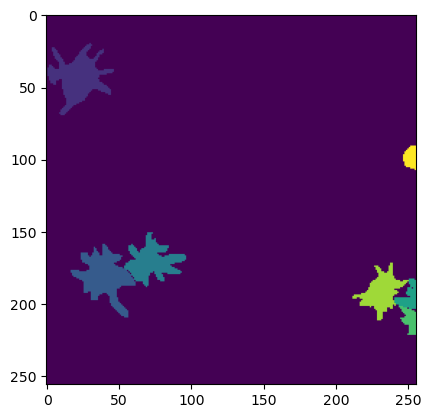

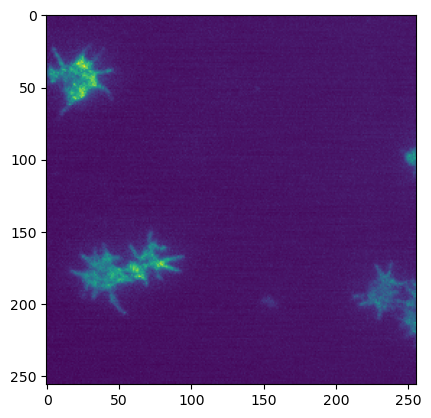

In [83]:

plt.imshow(large_masks[0])
plt.show()
plt.imshow(large_images[0])
plt.show()


In [84]:
# Desired patch size for smaller images and step size.
# IMG DIMENTIONS MUST be divisible by patch_size and step

def create_image_patches(large_images, large_masks, patch_size, step):
    # patch_size:       Size of the patches
    # step:             Size of the step (if step == patch_size, no overlap will occur)
    all_img_patches = []
    for img in range(large_images.shape[0]):
        large_image = large_images[img]
        patches_img = patchify(large_image, (patch_size, patch_size), step=step)

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):

                single_patch_img = patches_img[i,j,:,:]
                all_img_patches.append(single_patch_img)

    images = np.array(all_img_patches)

    #Let us do the same for masks
    all_mask_patches = []
    for img in range(large_masks.shape[0]):
        large_mask = large_masks[img]
        patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)

        for i in range(patches_mask.shape[0]):
            for j in range(patches_mask.shape[1]):

                single_patch_mask = patches_mask[i,j,:,:]
                # single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
                all_mask_patches.append(single_patch_mask)

    masks = np.array(all_mask_patches)

    return images, masks

In [85]:
# Desired patch size for smaller images and step size.
# IMG DIMENTIONS MUST be divisible by patch_size and step

def create_patches(large_images, patch_size, step):
    # patch_size:       Size of the patches
    # step:             Size of the step (if step == patch_size, no overlap will occur)
    all_img_patches = []
    for img in range(large_images.shape[0]):
        large_image = large_images[img]
        patches_img = patchify(large_image, (patch_size, patch_size), step=step)

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):

                single_patch_img = patches_img[i,j,:,:]
                all_img_patches.append(single_patch_img)

    images = np.array(all_img_patches)

    return images

In [86]:
def total_data_augmentation(large_images, patch_size, step, rotate, flip):
    rotations_images = []
    for i in range(large_images.shape[0]):
        # Add all possible rotations here
        rotations_images.append(large_images[i])
        
        if (rotate == True):
            rotations_images.append(np.rot90(large_images[i], 1))
            rotations_images.append(np.rot90(large_images[i], 2))
            rotations_images.append(np.rot90(large_images[i], 3))
        
        if (flip == True):
            rotations_images.append(np.fliplr(large_images[i]))
            
            if (rotate == True):
                rotations_images.append(np.rot90(np.fliplr(large_images[i]), 1))
                rotations_images.append(np.rot90(np.fliplr(large_images[i]), 2))
                rotations_images.append(np.rot90(np.fliplr(large_images[i]), 3))

    rotations_images = np.array(rotations_images)

    final_images = create_patches(rotations_images, patch_size=patch_size, step=step)

    return final_images

In [254]:
# images, masks = create_patches(large_images=large_images, large_masks=large_masks, patch_size=128, step=128)
images = total_data_augmentation(large_images, patch_size=256, step=256, flip=True, rotate=True)
masks = total_data_augmentation(large_masks, patch_size=256, step=256, flip=True, rotate=True)

Image shape: (808, 256, 256)
Mask shape: (808, 256, 256)


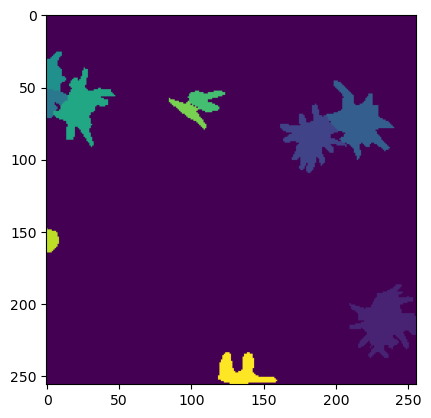

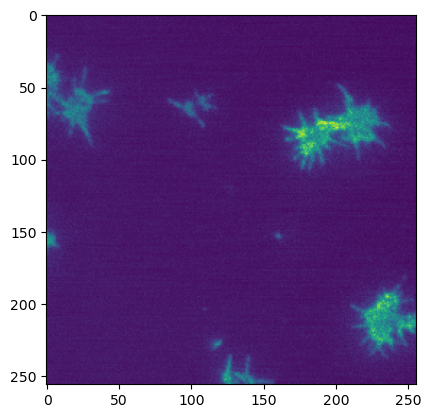

In [256]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

i = random.randrange(0, filtered_masks.shape[0])

plt.imshow(filtered_masks[i])
plt.show()
plt.imshow(filtered_images[i])

In [ ]:
# Data Augmentation For All Files in a folder
# NOTES: Please create an empty folder for the files before running this function

def full_data_augmentation_pipline(input_images_folder, 
                                   input_masks_folder, 
                                   output_images_folder, 
                                   output_masks_folder, 
                                   patch_size, step, flip, rotate):
    image_path_list = [i for i in os.listdir(input_images_folder) if i.endswith('.tif')]
    image_path_list.sort()

    mask_path_list = [i for i in os.listdir(input_masks_folder) if i.endswith('.tif')]
    mask_path_list.sort()
    # Now both lists should be in the same order if named correctly

    print(image_path_list)
    print(mask_path_list)

    for i in range(len(image_path_list)):
        image_path = input_images_folder + "/"+ image_path_list[i]
        mask_path = input_masks_folder + "/"+ mask_path_list[i]
        print(input_images_folder)
        print(image_path_list[i])
        print(image_path)

        mask_preprocessing(image_path, mask_path)
        large_images = tifffile.imread(image_path)
        large_masks = tifffile.imread(mask_path)


        augmented_images = total_data_augmentation(large_images, patch_size=patch_size, step=step, flip=flip, rotate=rotate)
        augmented_masks = total_data_augmentation(large_masks, patch_size=patch_size, step=step, flip=flip, rotate=rotate)

        output_image_path = output_images_folder +"/"+ image_path_list[i]
        output_mask_path = output_masks_folder +"/"+ mask_path_list[i]
        
        tifffile.imwrite(output_image_path, augmented_images)
        tifffile.imwrite(output_mask_path, augmented_masks)


In [258]:
full_data_augmentation_pipline(input_images_folder="/Users/jakesolsky/PlateletImageSegmentation/Data/Training Data/Raw/Images",
                               input_masks_folder="/Users/jakesolsky/PlateletImageSegmentation/Data/Training Data/Raw/Masks",
                               output_images_folder="/Users/jakesolsky/PlateletImageSegmentation/Data/Training Data/Rotate_Flip/Images",
                               output_masks_folder="/Users/jakesolsky/PlateletImageSegmentation/Data/Training Data/Rotate_Flip/Masks",
                               patch_size=256, step=256, flip=True, rotate=True)

['S2.tif', 'S3.tif', 'S4.tif']
['Mask_S2.tif', 'Mask_S3.tif', 'Mask_S4.tif']
/Users/jakesolsky/PlateletImageSegmentation/Data/Training Data/Raw/Images
S2.tif
/Users/jakesolsky/PlateletImageSegmentation/Data/Training Data/Raw/Images/S2.tif
/Users/jakesolsky/PlateletImageSegmentation/Data/Training Data/Raw/Images
S3.tif
/Users/jakesolsky/PlateletImageSegmentation/Data/Training Data/Raw/Images/S3.tif
/Users/jakesolsky/PlateletImageSegmentation/Data/Training Data/Raw/Images
S4.tif
/Users/jakesolsky/PlateletImageSegmentation/Data/Training Data/Raw/Images/S4.tif


(101, 128, 128)
segmentation_SAM


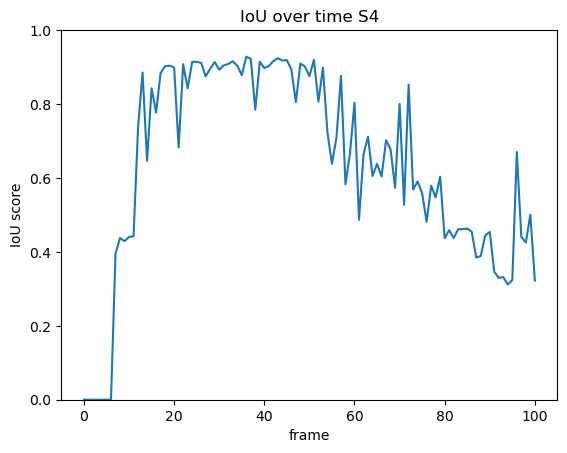

segmentation_SAM_finetunes


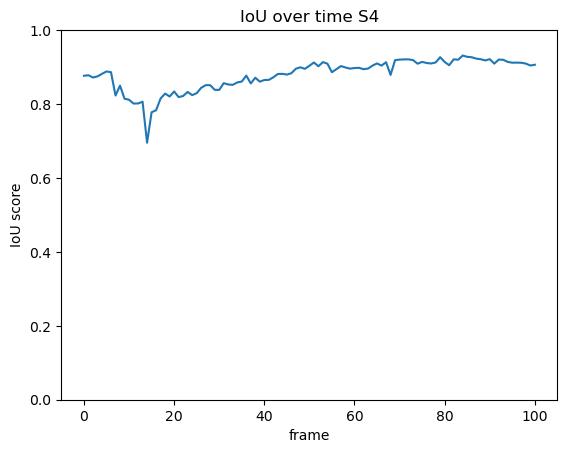

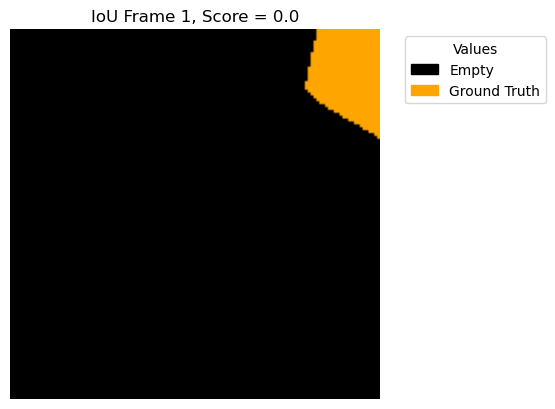

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


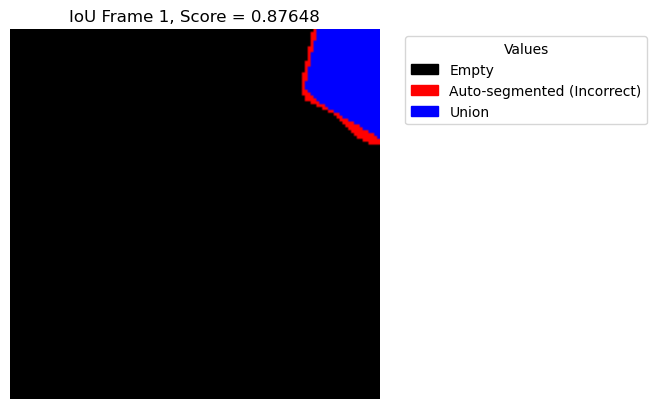

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


(101, 128, 128)
segmentation_SAM


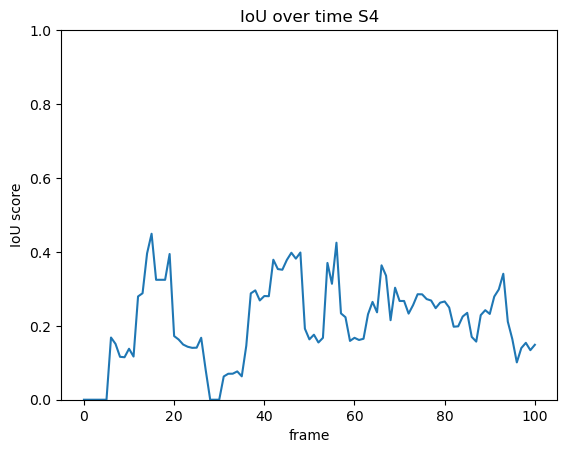

segmentation_SAM_finetunes


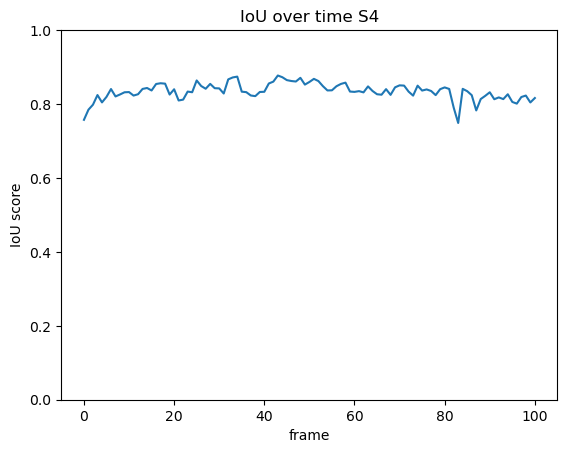

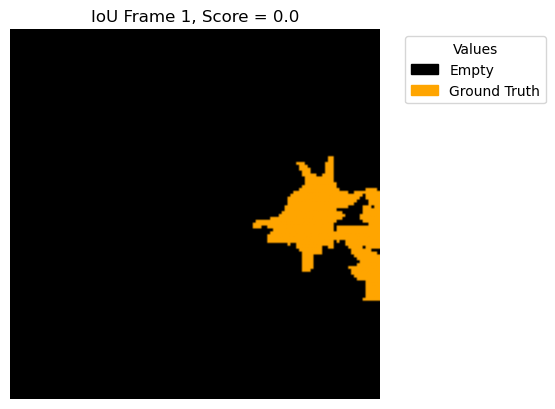

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


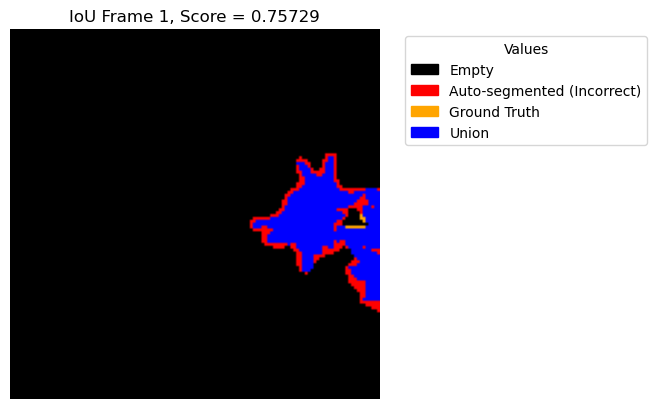

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


(101, 128, 128)
segmentation_SAM


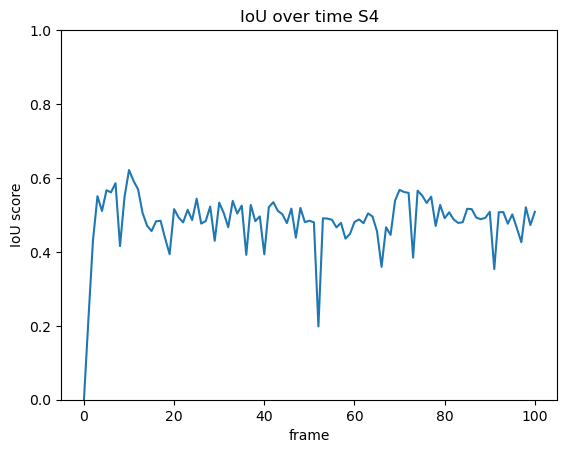

segmentation_SAM_finetunes


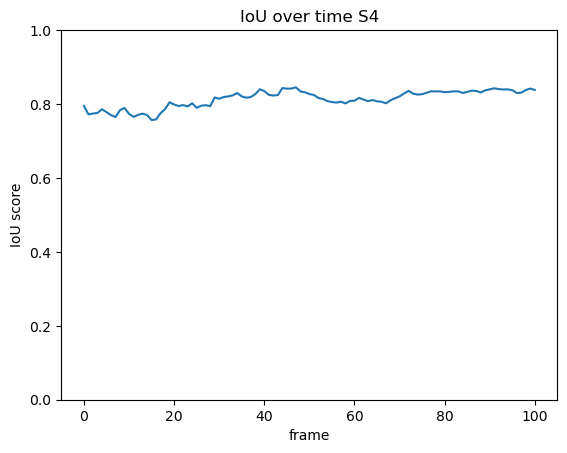

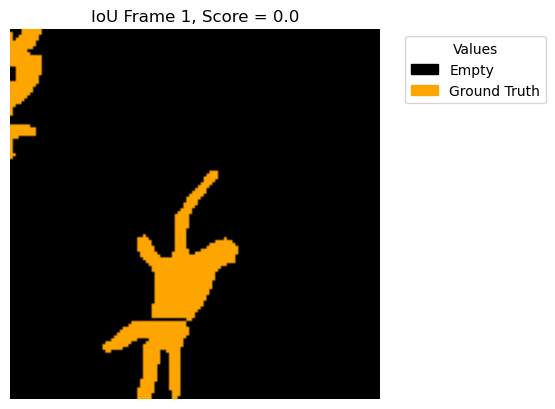

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


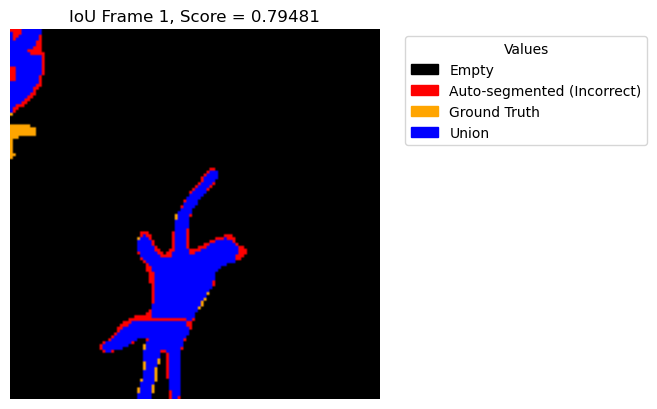

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.PillowWriter'>


In [ ]:
for i in range(len(ground_paths)):
    ground = tifffile.imread(ground_paths[i])
    ground = ground[:, 128:256, 128:256]
    
    segmentation_SAM = tifffile.imread(SAM_output_paths[i])
    segmentation_SAM_finetuned = tifffile.imread(SAM_finetuned_output_paths[i])
    print(ground.shape)

    print("segmentation_SAM")
    plot_IoU_over_time(ground=ground, segmentation=segmentation_SAM)
    plt.show()
    print("segmentation_SAM_finetuned")
    plot_IoU_over_time(ground=ground, segmentation=segmentation_SAM_finetuned)
    plt.show()

    anim = animate_IoU_plot(ground_stack=ground, segmentation_stack=segmentation_SAM)
    anim.save(f"iou_animation_S{i+2}.gif", writer="pillow", fps=5)

    anim = animate_IoU_plot(ground_stack=ground, segmentation_stack=segmentation_SAM_finetuned)
    anim.save(f"iou_animation_S{i+2}_finetuned.gif", writer="pillow", fps=5)
    